In [1]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recurrent Neural Networks

- A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes can create a cycle, allowing output from some nodes to affect subsequent input to the same nodes. This allows it to exhibit temporal dynamic behavior. 
- Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs.
- A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. 
- These deep learning algorithms are commonly used for ordinal or temporal problems, such as language translation, natural language processing (nlp), speech recognition, and image captioning

#Extracting Data

In [2]:
import zipfile

# Set the path to the zip file and the destination folder
zip_file_path = '/content/drive/MyDrive/DL Lab4/data (1).zip'
destination_folder = '/content/drive/MyDrive/DL Lab4/'

# Open and extract the zip file to the destination folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# Print a message to confirm the extraction
print('The zip file has been extracted to', destination_folder)


The zip file has been extracted to /content/drive/MyDrive/DL Lab4/


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('/content/drive/MyDrive/DL Lab4/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/MyDrive/DL Lab4/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/drive/MyDrive/DL Lab4/data/names/Arabic.txt', '/content/drive/MyDrive/DL Lab4/data/names/Chinese.txt', '/content/drive/MyDrive/DL Lab4/data/names/Czech.txt', '/content/drive/MyDrive/DL Lab4/data/names/Dutch.txt', '/content/drive/MyDrive/DL Lab4/data/names/English.txt', '/content/drive/MyDrive/DL Lab4/data/names/French.txt', '/content/drive/MyDrive/DL Lab4/data/names/German.txt', '/content/drive/MyDrive/DL Lab4/data/names/Greek.txt', '/content/drive/MyDrive/DL Lab4/data/names/Irish.txt', '/content/drive/MyDrive/DL Lab4/data/names/Italian.txt', '/content/drive/MyDrive/DL Lab4/data/names/Japanese.txt', '/content/drive/MyDrive/DL Lab4/data/names/Korean.txt', '/content/drive/MyDrive/DL Lab4/data/names/Polish.txt', '/content/drive/MyDrive/DL Lab4/data/names/Portuguese.txt', '/content/drive/MyDrive/DL Lab4/data/names/Russian.txt', '/content/drive/MyDrive/DL Lab4/data/names/Scottish.txt', '/content/drive/MyDrive/DL Lab4/data/names/Spanish.txt', '/content/drive/MyDrive/DL Lab4/data/n

In [4]:
all_letters, all_categories

("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'",
 ['Arabic',
  'Chinese',
  'Czech',
  'Dutch',
  'English',
  'French',
  'German',
  'Greek',
  'Irish',
  'Italian',
  'Japanese',
  'Korean',
  'Polish',
  'Portuguese',
  'Russian',
  'Scottish',
  'Spanish',
  'Vietnamese'])



* To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.
* To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.






In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


#Initial RNN

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def hidf(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).cuda()

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [ ]:
ddf = []
for k in category_lines:
    for words in category_lines[k]:
        ddf.append((k, words))

In [8]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(ddf,test_size=0.2)
df_val,df_test=train_test_split(df_test,test_size=0.5)

In [10]:
from collections import defaultdict

def f(ddf):
    cl = defaultdict(list)
    [cl[category].append(words) for category, words in ddf]
    return cl

In [11]:
train_12=f(df_train)
test_12=f(df_test)
val_12=f(df_val)

In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_12[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
def randomTestingExample():
    category = randomChoice(all_categories)
    line = randomChoice(test_12[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
def randomValidationExample():
    category = randomChoice(all_categories)
    line = randomChoice(val_12[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomValidationExample()
    print('category =', category, '/ line =', line)

## HYper parameter tuning case 1:

In [13]:
criterion1 = nn.NLLLoss()
learning_rate1 = 0.001
optimizer1 = torch.optim.SGD(rnn.parameters(),lr= learning_rate1)

In [14]:
def train(category_tensor, line_tensor, optimizer):
    hidden = rnn.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion1(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [15]:
def val(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion1(output, category_tensor.to(device))

    return output, loss.item()


In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn, optimizer1, criterion1)


5000 5% (0m 18s) 2.8245 Di caprio / Portuguese ✗ (Italian)
10000 10% (0m 34s) 2.6776 Prokofiev / Russian ✓
15000 15% (0m 48s) 2.8628 Nesbitt / French ✗ (English)
20000 20% (1m 2s) 2.8381 Khoury / Russian ✗ (Arabic)
25000 25% (1m 17s) 2.5297 Siegel / Dutch ✗ (German)
30000 30% (1m 32s) 1.5962 Dong / Chinese ✓
35000 35% (1m 48s) 2.4394 Seeger / German ✗ (Dutch)
40000 40% (2m 3s) 2.5469 Quigley / Portuguese ✗ (Irish)
45000 45% (2m 19s) 2.6492 Bengochea / Czech ✗ (Spanish)
50000 50% (2m 37s) 2.2038 Mulder / German ✗ (Dutch)
55000 55% (2m 54s) 1.1054 Zhao / Chinese ✓
60000 60% (3m 10s) 1.6591 Romijnders / Dutch ✓
65000 65% (3m 26s) 0.1394 Takishita / Japanese ✓
70000 70% (3m 40s) 1.5743 Polites / Greek ✓
75000 75% (3m 55s) 1.1265 Wilson / Scottish ✓
80000 80% (4m 11s) 3.4578 Panzavecchia / Russian ✗ (Italian)
85000 85% (4m 27s) 5.4888 Jippensha / Polish ✗ (Japanese)
90000 90% (4m 43s) 1.9475 Platt / Scottish ✗ (English)
95000 95% (4m 57s) 2.0156 Makricosta / Russian ✗ (Greek)
100000 100% (5

In [96]:
def evaluate(line_tensor):
    hidden = rnn.hidf()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [18]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

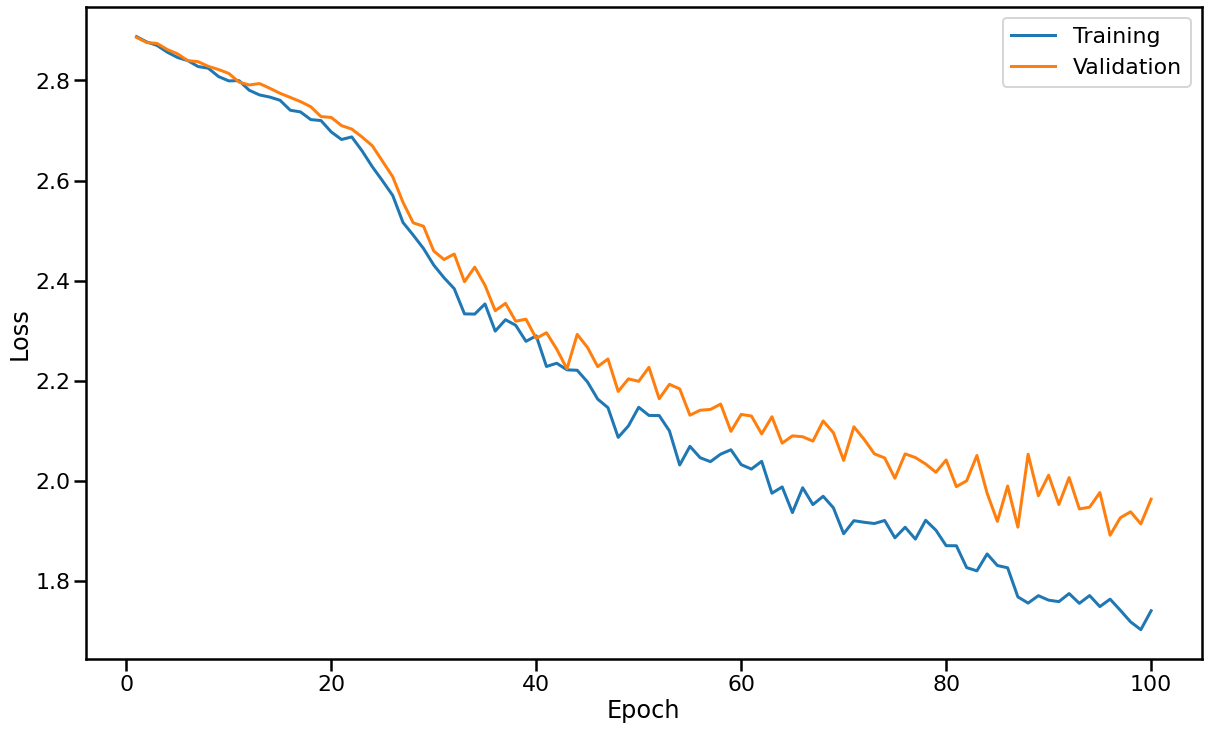

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 2

In [20]:
criterion2 = nn.NLLLoss()
learning_rate2 = 0.01
optimizer2 = torch.optim.SGD(rnn.parameters(),lr= learning_rate1)

In [21]:
def train(category_tensor, line_tensor, optimizer):
    hidden = rnn.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion2(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [22]:
def val(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion2(output, category_tensor.to(device))

    return output, loss.item()


In [23]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn, optimizer2, criterion2)


5000 5% (0m 15s) 0.2837 Horiatis / Greek ✓
10000 10% (0m 29s) 0.4039 Takeuchi / Japanese ✓
15000 15% (0m 47s) 2.9384 Spinks / Polish ✗ (English)
20000 20% (1m 3s) 3.0344 Rompuy / Portuguese ✗ (Dutch)
25000 25% (1m 19s) 2.5145 Durant / Vietnamese ✗ (English)
30000 30% (1m 33s) 0.2227 Tropinov / Russian ✓
35000 35% (1m 50s) 0.4030 Tarantino / Italian ✓
40000 40% (2m 8s) 0.6376 Shammas / Arabic ✓
45000 45% (2m 27s) 1.6979 Casales / Portuguese ✗ (Spanish)
50000 50% (2m 43s) 0.2882 Hamilton / Scottish ✓
55000 55% (2m 59s) 0.0559 Pantelakos / Greek ✓
60000 60% (3m 15s) 0.5231 Paredes / Portuguese ✓
65000 65% (3m 32s) 0.7945 Rosario / Portuguese ✓
70000 70% (3m 48s) 2.8545 Stevenson / Russian ✗ (Scottish)
75000 75% (4m 2s) 3.0534 Bagrich / Irish ✗ (Russian)
80000 80% (4m 18s) 4.3366 Poingdestre / Dutch ✗ (French)
85000 85% (4m 37s) 2.0963 Simen / Dutch ✗ (German)
90000 90% (4m 53s) 3.5013 Adam / Arabic ✗ (French)
95000 95% (5m 11s) 0.2940 De la fontaine / French ✓
100000 100% (5m 29s) 0.1203 

In [24]:
def evaluate(line_tensor):
    hidden = rnn.hidf()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [25]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

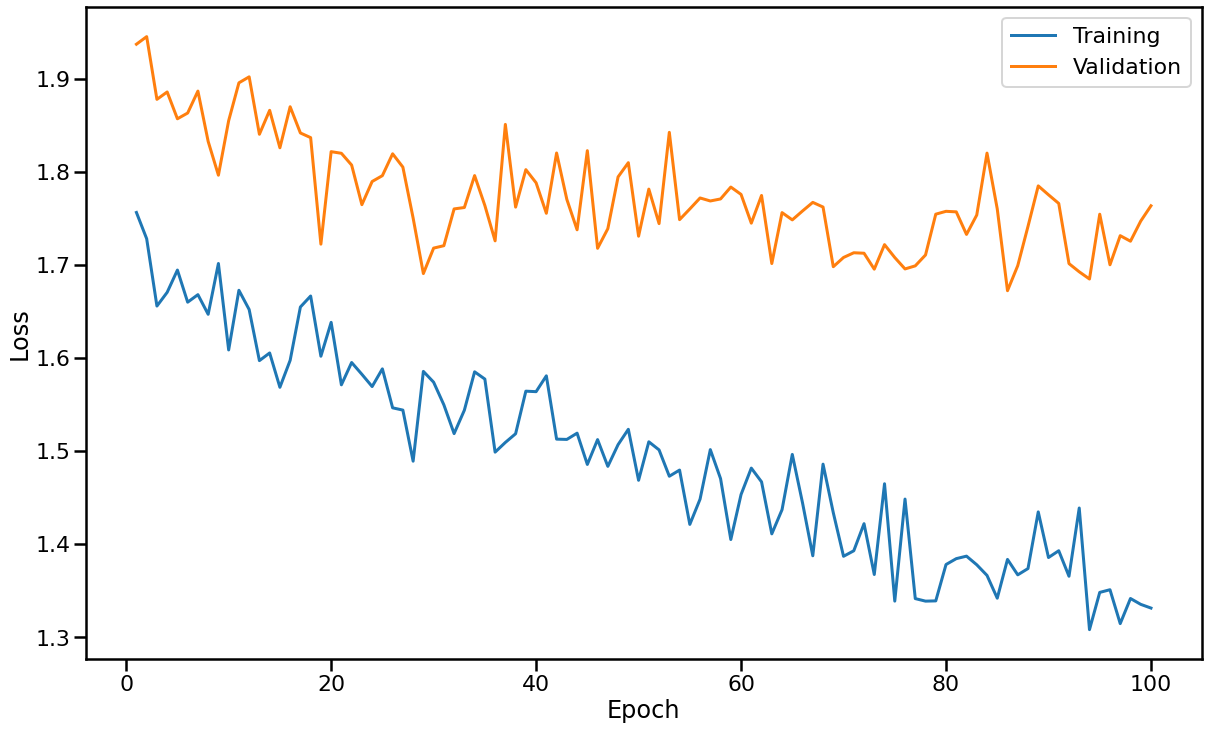

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 3

In [14]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(),lr= learning_rate)

In [15]:
def train(category_tensor, line_tensor, optimizer):
    hidden = rnn.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [16]:
def val(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion(output, category_tensor.to(device))

    return output, loss.item()


In [30]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion)


5000 5% (0m 15s) 0.8238 Koziol / Polish ✓
10000 10% (0m 30s) 0.7570 Woo / Korean ✓
15000 15% (0m 45s) 0.3178 Zhao / Chinese ✓
20000 20% (1m 0s) 0.3790 Yu / Korean ✓
25000 25% (1m 15s) 1.1161 Honjas / Greek ✓
30000 30% (1m 31s) 0.7478 Chin / Korean ✓
35000 35% (1m 46s) 3.2892 Kurtz / German ✗ (Czech)
40000 40% (2m 1s) 2.6609 Kranz / German ✗ (Dutch)
45000 45% (2m 16s) 0.6004 Nosek / Polish ✓
50000 50% (2m 31s) 3.1239 Fagan / Irish ✗ (English)
55000 55% (2m 46s) 0.2138 Ra / Korean ✓
60000 60% (3m 1s) 0.3348 Jin / Chinese ✓
65000 65% (3m 17s) 0.0007 Mcmillan / Scottish ✓
70000 70% (3m 32s) 0.7601 Ha / Vietnamese ✓
75000 75% (3m 48s) 1.7763 Marquering / Italian ✗ (Dutch)
80000 80% (4m 4s) 0.5182 Ghannam / Arabic ✓
85000 85% (4m 19s) 2.5449 Gouveia / Spanish ✗ (Portuguese)
90000 90% (4m 35s) 0.8967 Sokolof / Polish ✓
95000 95% (4m 50s) 0.6666 Vardy / English ✓
100000 100% (5m 6s) 1.8838 Moreno / Spanish ✗ (Portuguese)


In [18]:
line_tensor.shape

torch.Size([6, 1, 57])

In [19]:
def evaluate(line_tensor):
    hidden = rnn.hidf()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [20]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.57) Russian
(-1.17) Czech
(-3.06) English

> Jackson
(-0.51) Scottish
(-1.78) English
(-2.68) Russian

> Satoshi
(-0.68) Arabic
(-1.78) Polish
(-1.93) Japanese


In [24]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

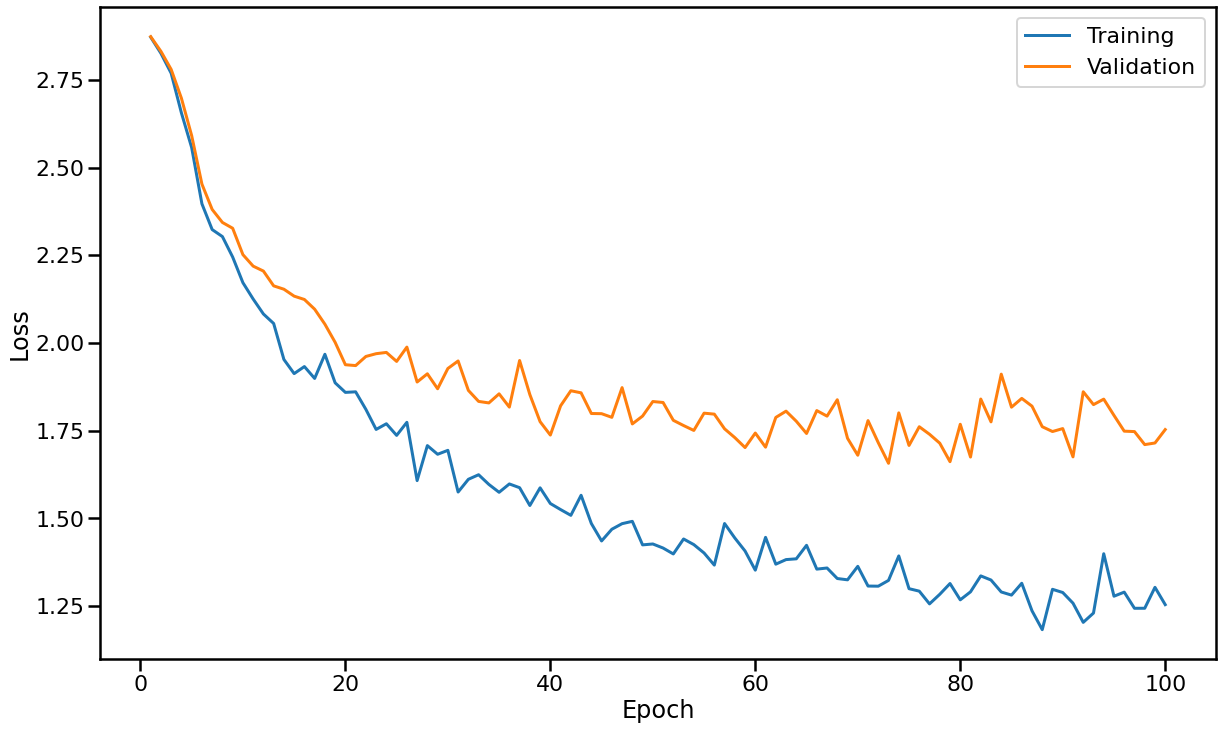

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [90]:
# Prepare the validation data
val_categories = []
val_lines = []
for category, lines in val_12.items():
    for line in lines:
        # print(category)
        val_categories.append(category)
        val_lines.append(lineToTensor(line))
# val_categories[1]
# val_lines[0]

In [91]:
def evaluate_val(line_tensor,model):
    hidden = model.hidf()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

##Hyperparameter tuning case 4

In [27]:
criterion4 = nn.NLLLoss()
learning_rate4 = 0.001
optimizer4 = torch.optim.Adam(rnn.parameters(),lr= learning_rate4)

In [28]:
def val(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion4(output, category_tensor.to(device))

    return output, loss.item()


In [31]:
def val(category_tensor, line_tensor):
   with torch.no_grad():
        hidden = rnn.hidf()
        hidden = hidden.to(device)
        line_tensor =line_tensor.to(device)
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion4(output, category_tensor.to(device))
        return output,loss

In [32]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn, optimizer4, criterion4)


5000 5% (0m 16s) 1.0962 Silveira / Portuguese ✓
10000 10% (0m 34s) 2.0029 Diarmaid / French ✗ (Irish)
15000 15% (0m 55s) 0.7713 Kanaan / Arabic ✓
20000 20% (1m 11s) 2.7675 Smith / Scottish ✗ (Czech)
25000 25% (1m 28s) 1.6431 Teague / French ✗ (Irish)
30000 30% (1m 46s) 0.0372 Dalianis / Greek ✓
35000 35% (2m 3s) 0.4107 Piontek / Polish ✓
40000 40% (2m 26s) 0.1907 Mao / Chinese ✓
45000 45% (2m 43s) 0.6371 Hutmacher / German ✓
50000 50% (3m 3s) 1.9878 an / Irish ✗ (Vietnamese)
55000 55% (3m 21s) 0.4263 Gomes / Portuguese ✓
60000 60% (3m 38s) 0.2481 Torres / Portuguese ✓
65000 65% (4m 2s) 0.6657 Ferreira / Portuguese ✓
70000 70% (4m 19s) 0.0896 Dioletis / Greek ✓
75000 75% (4m 43s) 2.4887 Zeni / Chinese ✗ (Italian)
80000 80% (5m 4s) 0.1667 Judakhin / Russian ✓
85000 85% (5m 20s) 1.8891 Mclaughlin / Russian ✗ (Scottish)
90000 90% (5m 38s) 0.2343 Ron / Korean ✓
95000 95% (5m 54s) 0.2010 Mustafa / Arabic ✓
100000 100% (6m 11s) 1.0451 Richter / German ✓


In [33]:
def evaluate(line_tensor):
    hidden = rnn.hidf()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [34]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

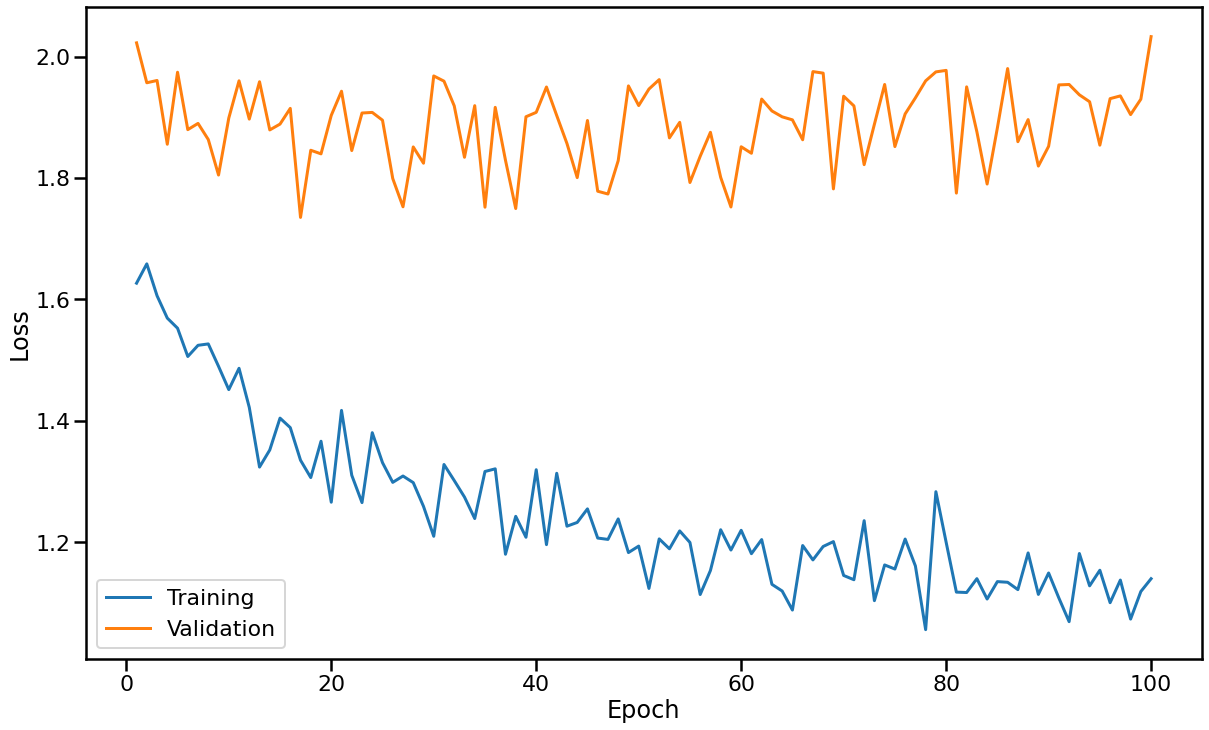

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 5

In [36]:
criterion5 = nn.NLLLoss()
learning_rate5 = 0.005
optimizer5 = torch.optim.Adam(rnn.parameters(),lr= learning_rate5)

In [37]:
def train(category_tensor, line_tensor, optimizer):
    hidden = rnn.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion5(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [38]:
def val(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion5(output, category_tensor.to(device))

    return output, loss.item()


In [39]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn, optimizer5, criterion5)


5000 5% (0m 17s) 63.8726 Rios / Vietnamese ✗ (Portuguese)
10000 10% (0m 35s) 5280.7305 Sokal / Greek ✗ (Polish)
15000 15% (0m 52s) 906.7394 Katsu / English ✗ (Japanese)
20000 20% (1m 12s) 189364272.0000 Costantini / Spanish ✗ (Italian)
25000 25% (1m 30s) 72179304.0000 Schumacher / Irish ✗ (German)
30000 30% (1m 50s) 1331968.8750 Kurmochi / Spanish ✗ (Japanese)
35000 35% (2m 6s) 23551.1875 Jadenov / Irish ✗ (Russian)
40000 40% (2m 23s) 267.5229 Jang / Russian ✗ (Korean)
45000 45% (2m 40s) 102578.1250 Robledo / French ✗ (Spanish)
50000 50% (2m 57s) 1754.1646 Falco / Czech ✗ (Italian)
55000 55% (3m 13s) 172517.6250 Rowland / German ✗ (English)
60000 60% (3m 29s) 2165.3086 Fabbro / Russian ✗ (Italian)
65000 65% (3m 47s) 160.8823 Nijo / Russian ✗ (Japanese)
70000 70% (4m 3s) 86738.4766 Haprov / German ✗ (Russian)
75000 75% (4m 20s) 13478.2617 Romero / Greek ✗ (Italian)
80000 80% (4m 36s) 6262671.0000 Noguerra / Greek ✗ (Spanish)
85000 85% (4m 53s) 6083683.0000 Missiakos / German ✗ (Greek)
9

In [40]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

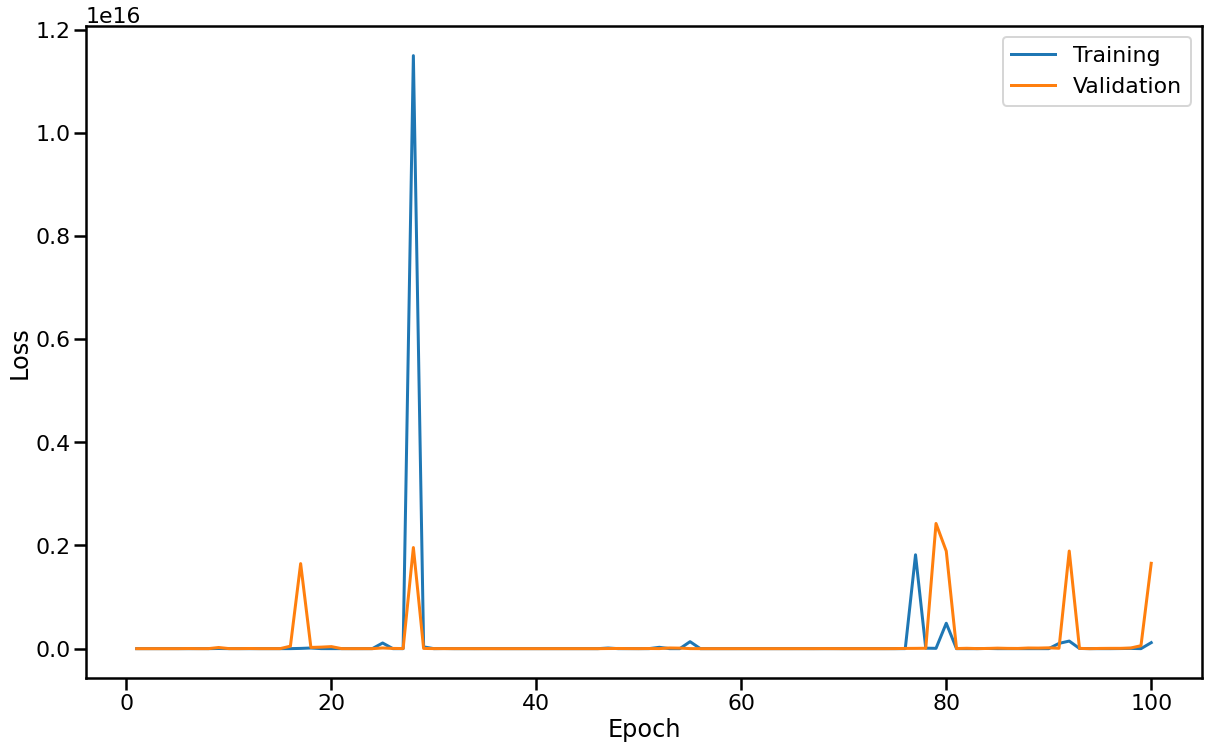

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 6

In [42]:
criterion6 = nn.NLLLoss()
learning_rate6 = 0.01
optimizer6 = torch.optim.Adam(rnn.parameters(),lr= learning_rate6)

In [43]:
def train(category_tensor, line_tensor, optimizer):
    hidden = rnn.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion6(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [44]:
def val(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion6(output, category_tensor.to(device))

    return output, loss.item()


In [45]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn, optimizer6, criterion6)


5000 5% (0m 16s) 8479102.0000 Ogiwara / Greek ✗ (Japanese)
10000 10% (0m 32s) 0.0000 Kerner / Czech ✓
15000 15% (0m 49s) 5.2777 Mo / Italian ✗ (Korean)
20000 20% (1m 6s) 1136323.3750 Franco / Russian ✗ (Portuguese)
25000 25% (1m 23s) 4696524800.0000 Muhlbauer / Russian ✗ (Czech)
30000 30% (1m 41s) 0.4867 Ola / Spanish ✓
35000 35% (2m 4s) 1254628992.0000 Chastain / Dutch ✗ (French)
40000 40% (2m 23s) 1436.1171 Komo / Spanish ✗ (Czech)
45000 45% (2m 42s) 30286616576.0000 Acciaioli / Greek ✗ (Italian)
50000 50% (3m 10s) 280052039680.0000 Wawrzaszek / Russian ✗ (Polish)
55000 55% (3m 26s) 46491884.0000 Lauwens / Russian ✗ (Dutch)
60000 60% (3m 47s) 22404184.0000 Michaud / Greek ✗ (French)
65000 65% (4m 7s) 81425.5234 Finke / Dutch ✗ (Czech)
70000 70% (4m 32s) 2149677.2500 Harvey / Italian ✗ (English)
75000 75% (4m 52s) 156779264.0000 Kuijpers / English ✗ (Dutch)
80000 80% (5m 9s) 103725624.0000 Ramaker / French ✗ (Dutch)
85000 85% (5m 29s) 2488905362309120.0000 Christodoulou / Portuguese ✗

In [46]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

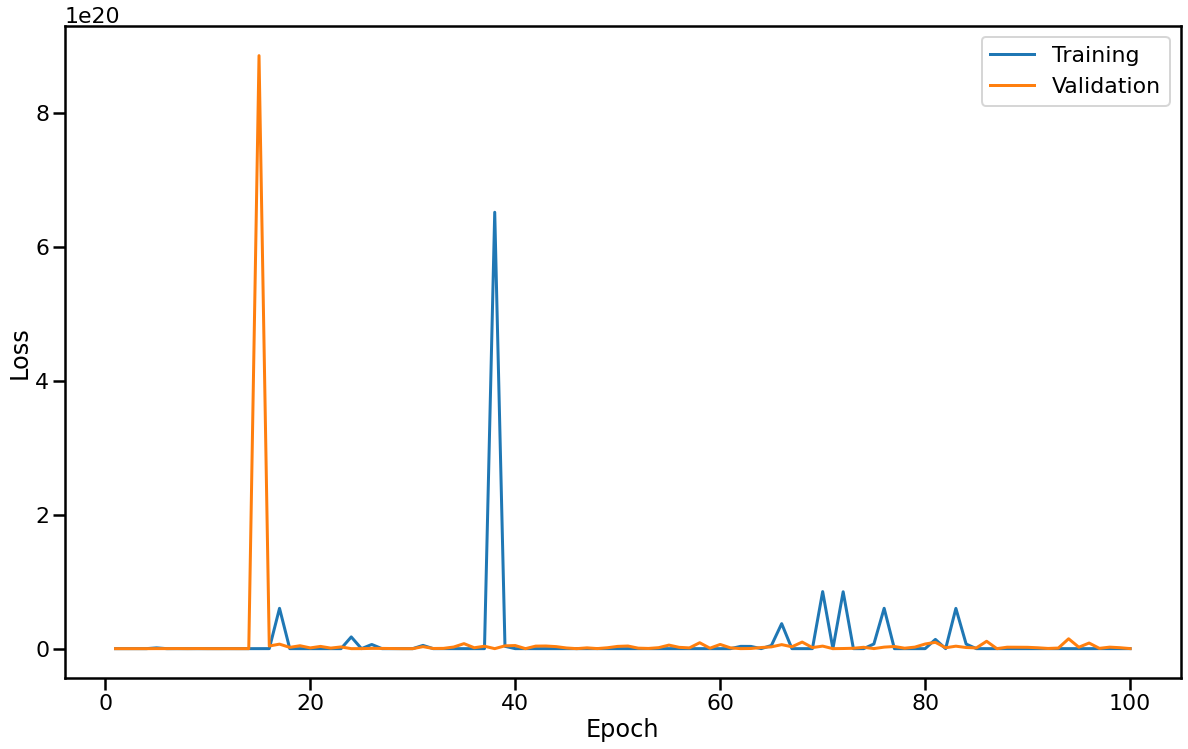

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Best Model- Optimizer : SGD & Learning Rate: 0.01

##Loading the best model & Confusion Matrix

tensor([[  0.,   0.,   0.,   8.,   0.,  16.,   0.,   6.,   2.,   0.,   0.,   0.,
           0.,   3.,   9.,   0.,   0.,   1.],
        [  1.,   0.,   0.,   4.,   0.,   4.,   2.,   3.,   4.,   1.,   0.,   0.,
           1.,   2.,   5.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   1.,   0.,   0.,   0.,   1.],
        [  0.,   1.,   0.,  15.,   2.,  14.,   0.,  10.,   5.,   0.,   0.,   0.,
           2.,   0.,  10.,   0.,   0.,   6.],
        [  2.,   0.,   0.,   3.,   1.,   5.,   1.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.,   5.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   6.,   1.,   1.,   0.,   5.,   2.,   0.,   0.,   0.,
           0.,   2.,   8.,   1.,   0.,   1.],
        [  0.,   0.,   0.,   2.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   3.,   0.,   1.,   0.],
        [  4.,   1.,   0.,   2.,   1.,   5.,   2.,   0.,   3.,   0.,   3.,   2.,
           0.,   0.,   1.,   0

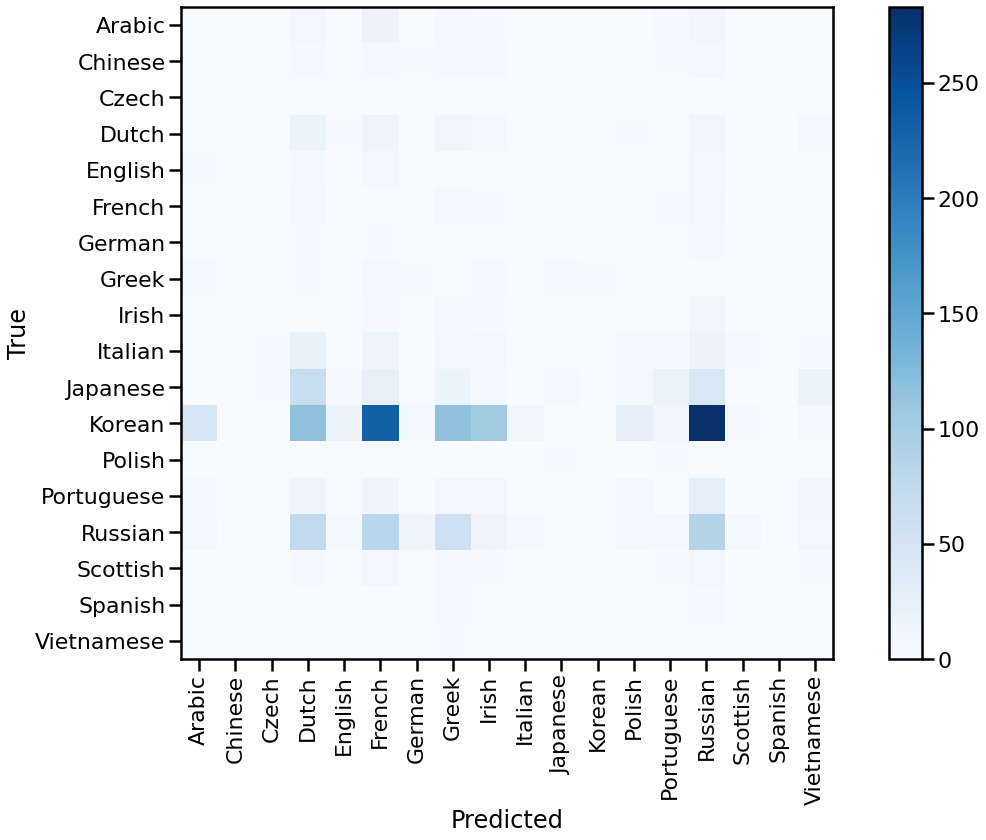

In [92]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
PATH = '/content/drive/MyDrive/DL Lab4/best_model.pth'
model = RNN(n_letters, n_hidden, n_categories).to(device)
model = torch.load(PATH)

#Putting model in evaluation mode
rnn.eval()

# Create confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# print(confusion[0][0])
# with torch.no_grad():
# for i in val_categories:
#   print(i)
val_cat_dict={'Czech':0,
  'Dutch':1,
  'Portuguese':2,
  'Italian':3,
  'Irish':4,
  'French':5,
  'Polish':6,
  'Chinese':7,
  'Greek':8,
  'German':9,
  'Arabic':10,
  'Russian':11,
  'Korean':12,
  'Japanese':13,
  'English':14,
  'Spanish':15,
  'Scottish':16,
  'Vietnamese':17}
for i in range(len(val_categories)):
    output = evaluate(val_lines[i])
    guess = torch.argmax(output)
    category_i = val_cat_dict[val_categories[i]]
    # print(guess,' ',category_i)
    confusion[category_i][guess]+=1

# Print confusion matrix
print(confusion)

# Plot confusion matrix
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.imshow(confusion.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(all_categories))
plt.xticks(tick_marks, all_categories, rotation=90)
plt.yticks(tick_marks, all_categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [99]:
# Load the saved best model
# n_hidden = 128
# rnn_1 = RNN(n_letters, n_hidden, n_categories)
# state_dict = torch.load('best_model_1.pt')
# rnn_1.load_state_dict(state_dict)

# Define the function to predict the category of a given line using the loaded model
# def predict(line):
#     with torch.no_grad():
#         line_tensor = lineToTensor(line)
#         hidden = model.hidf()

#         for i in range(line_tensor.size()[0]):
#             output, hidden = model(line_tensor[i], hidden)

#         return output

# Iterate through the test ddf and predict the category for each line
correct = 0
total = 0

for category, lines in df_test:
    for line in lines:
        output = predict(line)
        print(type(output))
        _, predicted = torch.max(output, 1)
        total += 1
        if all_categories[predicted[0]] == category:
            correct += 1

# Calculate the test accuracy by comparing the predicted category with the actual category
test_accuracy = correct / total
print('test accuracy',test_accuracy)

test accuracy 0.61


#RNN with layers added

In [48]:
import torch.nn as nn
import torch.nn.functional as F
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.hidden1 = nn.Linear(hidden_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = F.relu(hidden)
        hidden = self.hidden1(hidden)
        hidden = F.relu(hidden)
        hidden = self.hidden2(hidden)
        hidden = F.relu(hidden)
        hidden = self.hidden3(hidden)
        hidden = F.relu(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def hidf(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn2 = RNN2(n_letters, n_hidden, n_categories).cuda()

##Hyperparameter tuning case 1

In [49]:
criterion1 = nn.NLLLoss()
learning_rate = 0.001
optimizer1 = torch.optim.SGD(rnn.parameters(),lr= learning_rate)

In [50]:
def train2(category_tensor, line_tensor, optimizer):
    hidden = rnn2.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn2(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion1(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [51]:

def val2(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion1(output, category_tensor.to(device))

    return output, loss.item()


In [52]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn2, optimizer1, criterion1)


5000 5% (0m 33s) 2.9246 Molotkov / Scottish ✗ (Russian)
10000 10% (1m 5s) 2.8630 Baba / Japanese ✗ (Arabic)
15000 15% (1m 37s) 2.9227 Vickerman / Italian ✗ (English)
20000 20% (2m 16s) 2.8383 Wiater / Japanese ✗ (Polish)
25000 25% (2m 51s) 2.9306 Ngo / Scottish ✗ (Vietnamese)
30000 30% (3m 23s) 2.9647 Alves / Scottish ✗ (Portuguese)
35000 35% (3m 59s) 2.8984 Morandi / Scottish ✗ (Italian)
40000 40% (4m 38s) 2.9335 Woodhead / Italian ✗ (English)
45000 45% (5m 10s) 2.8546 Zhi / Scottish ✗ (Chinese)
50000 50% (5m 44s) 2.9350 Marquerink / Irish ✗ (German)
55000 55% (6m 23s) 2.8065 Kennedy / Italian ✗ (Scottish)
60000 60% (7m 7s) 3.0066 Huffman / Italian ✗ (German)
65000 65% (7m 47s) 2.9647 Fernandes / Scottish ✗ (Portuguese)
70000 70% (8m 30s) 2.8523 Chung / Japanese ✗ (Korean)
75000 75% (9m 12s) 2.9017 Ramos / Scottish ✗ (Spanish)
80000 80% (9m 52s) 2.8682 Qiu / Scottish ✗ (Chinese)
85000 85% (10m 27s) 2.8421 Govier / Japanese ✗ (English)
90000 90% (11m 2s) 2.9575 Eizenstein / Italian ✗ (

In [53]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

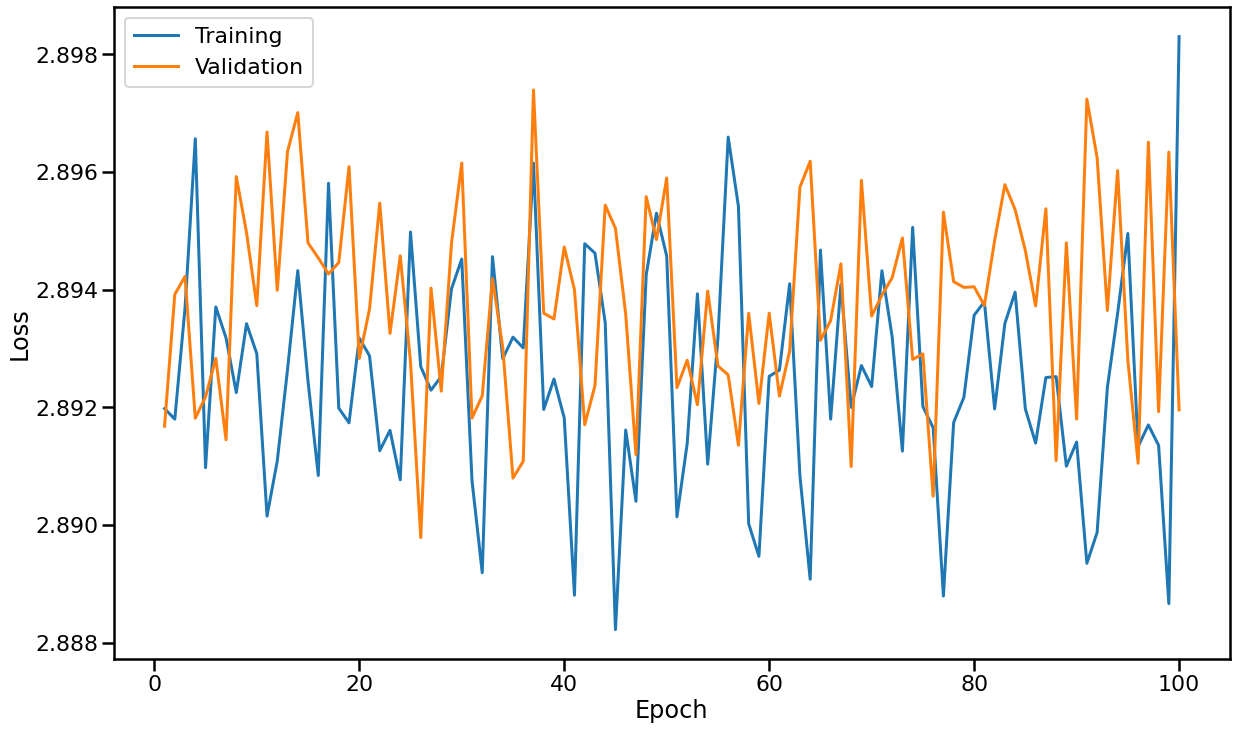

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 2

In [39]:
criterion2 = nn.NLLLoss()
learning_rate = 0.005
optimizer2 = torch.optim.SGD(rnn.parameters(),lr= learning_rate)

In [40]:
def train2(category_tensor, line_tensor, optimizer):
    hidden = rnn2.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn2(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion2(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [41]:
def val2(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion2(output, category_tensor.to(device))

    return output, loss.item()


In [59]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn2, optimizer2, criterion2)


5000 5% (0m 33s) 2.8098 Schubert / French ✗ (Czech)
10000 10% (1m 9s) 2.8776 Mateus / French ✗ (Portuguese)
15000 15% (1m 42s) 2.7674 Deschamps / French ✓
20000 20% (2m 16s) 2.8694 Venn / French ✗ (Dutch)
25000 25% (2m 49s) 2.8460 Sniders / French ✗ (Dutch)
30000 30% (3m 24s) 2.8951 Pletcher / English ✗ (German)
35000 35% (3m 58s) 2.7858 Whitehouse / English ✓
40000 40% (4m 33s) 2.7626 Herback / Czech ✓
45000 45% (5m 9s) 2.9360 OuYang / English ✗ (Chinese)
50000 50% (5m 44s) 2.8930 Twiggs / French ✗ (English)
55000 55% (6m 18s) 2.8200 O'Keeffe / English ✗ (Irish)
60000 60% (6m 52s) 2.8567 Jedynak / Czech ✗ (Polish)
65000 65% (7m 30s) 2.9575 Houk / Czech ✗ (German)
70000 70% (8m 5s) 2.9628 V'Yun / French ✗ (Russian)
75000 75% (8m 38s) 2.9978 Cha / English ✗ (Korean)
80000 80% (9m 13s) 2.8738 Duval / English ✗ (French)
85000 85% (9m 47s) 2.8597 Bouloukos / French ✗ (Greek)
90000 90% (10m 21s) 2.8001 Lefurgey / French ✓
95000 95% (10m 54s) 2.8551 Souza / English ✗ (Portuguese)
100000 100%

In [60]:
line_tensor.shape

torch.Size([8, 1, 57])

In [63]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

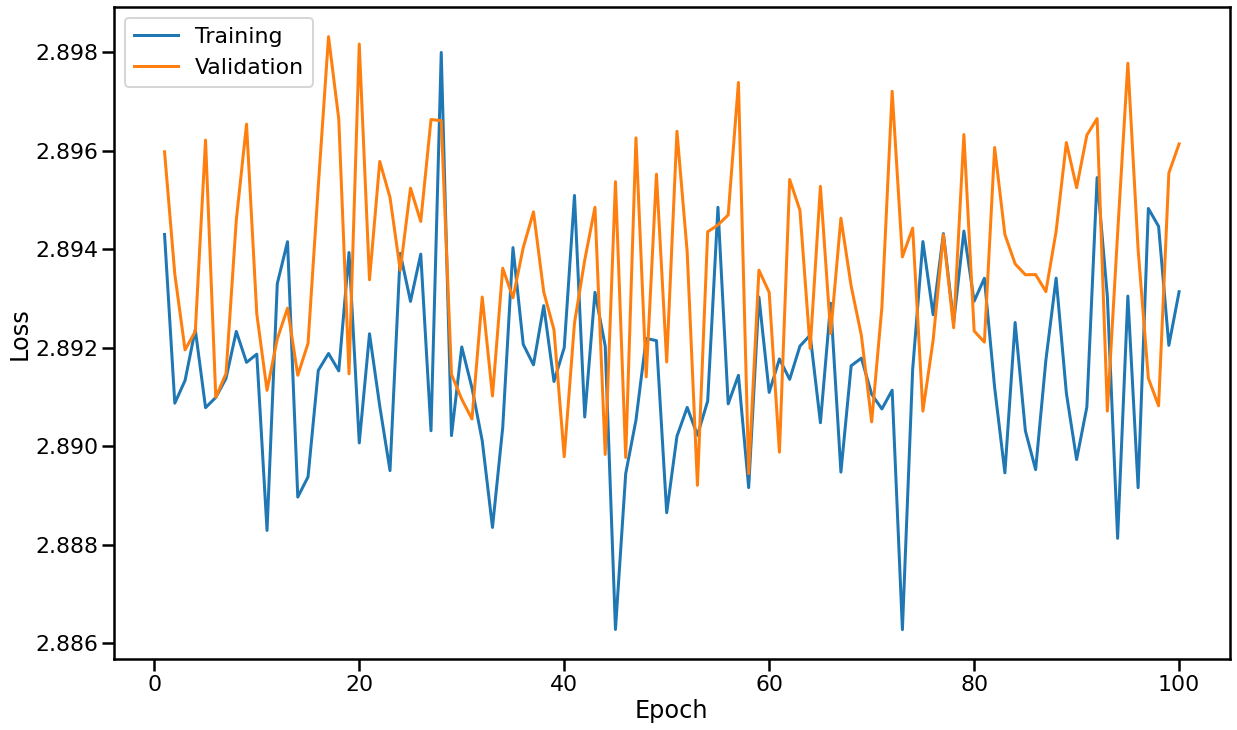

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 3

In [55]:
criterion3 = nn.NLLLoss()
learning_rate = 0.01
optimizer3 = torch.optim.SGD(rnn.parameters(),lr= learning_rate)

In [56]:
def train2(category_tensor, line_tensor, optimizer):
    hidden = rnn2.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn2(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion3(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [57]:
def val2(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion3(output, category_tensor.to(device))

    return output, loss.item()


In [58]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn2, optimizer3, criterion3)


5000 5% (0m 34s) 2.8655 Ming / Japanese ✗ (Chinese)
10000 10% (1m 23s) 2.9105 Chu / Scottish ✗ (Vietnamese)
15000 15% (1m 56s) 2.9627 Mateus / Scottish ✗ (Portuguese)
20000 20% (2m 29s) 2.8047 Kitao / Scottish ✗ (Japanese)
25000 25% (3m 2s) 2.9261 Jablonovsky / Italian ✗ (Russian)
30000 30% (3m 45s) 2.9002 Adamidis / Scottish ✗ (Greek)
35000 35% (4m 18s) 2.8519 Yun / Italian ✗ (Korean)
40000 40% (5m 16s) 2.9658 Schuchard / Italian ✗ (German)
45000 45% (5m 54s) 2.8869 Mifsud / Italian ✗ (Arabic)
50000 50% (6m 32s) 2.8604 Klein / Italian ✗ (Czech)
55000 55% (7m 11s) 2.9909 Vela / Japanese ✗ (Spanish)
60000 60% (7m 50s) 2.8028 Narato / Scottish ✗ (Japanese)
65000 65% (8m 24s) 2.8976 Wojewodka / Japanese ✗ (Polish)
70000 70% (8m 58s) 2.9240 Ebden / Italian ✗ (English)
75000 75% (9m 30s) 2.9166 Nghiem / Japanese ✗ (Vietnamese)
80000 80% (10m 4s) 2.8815 Zhuo / Scottish ✗ (Chinese)
85000 85% (10m 37s) 2.8654 Rong / Japanese ✗ (Chinese)
90000 90% (11m 11s) 2.9692 Pander / Japanese ✗ (Dutch)
95

In [59]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

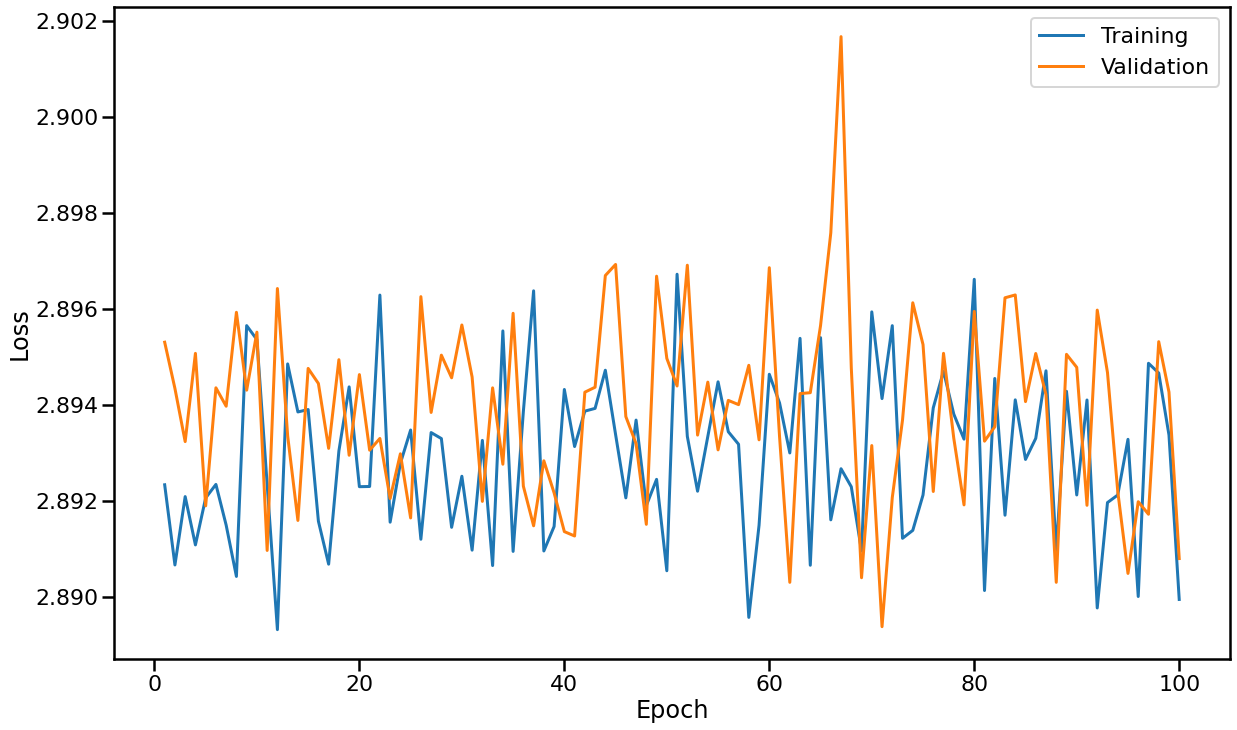

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 4

In [72]:
criterion4 = nn.NLLLoss()
learning_rate = 0.005
optimizer4 = torch.optim.Adam(rnn.parameters(),lr= learning_rate)

In [73]:
optimizer4

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.005
    maximize: False
    weight_decay: 0
)

In [74]:
def train2(category_tensor, line_tensor, optimizer):
    hidden = rnn2.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn2(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion4(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [75]:
def val2(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion4(output, category_tensor.to(device))

    return output, loss.item()


In [76]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn2, optimizer4, criterion4)


5000 5% (0m 36s) 2.9924 Esparza / Japanese ✗ (Spanish)
10000 10% (1m 13s) 2.8629 Gauk / Irish ✗ (Chinese)
15000 15% (1m 52s) 2.9246 Jatskov / Scottish ✗ (Russian)
20000 20% (2m 27s) 2.8986 Bagni / Scottish ✗ (Italian)
25000 25% (3m 2s) 2.9540 Levesque / Irish ✗ (French)
30000 30% (3m 40s) 2.9275 Tron / Italian ✗ (Vietnamese)
35000 35% (4m 24s) 2.8986 Abatescianni / Scottish ✗ (Italian)
40000 40% (5m 0s) 2.8526 Han / Italian ✗ (Korean)
45000 45% (5m 35s) 2.9003 Dioletis / Scottish ✗ (Greek)
50000 50% (6m 10s) 2.8982 Segreti / Scottish ✗ (Italian)
55000 55% (6m 45s) 3.0091 Fux / Scottish ✗ (German)
60000 60% (7m 21s) 2.9092 Chi / Scottish ✗ (Korean)
65000 65% (7m 58s) 2.8896 You / Scottish ✗ (Korean)
70000 70% (8m 32s) 2.7906 Nakagawa / Japanese ✓
75000 75% (9m 11s) 2.8386 Fleming / Japanese ✗ (Scottish)
80000 80% (9m 49s) 2.8549 Daal / Scottish ✗ (Dutch)
85000 85% (10m 25s) 2.8077 Jung  / Korean ✓
90000 90% (10m 59s) 2.7855 O'Byrne / Irish ✓
95000 95% (11m 34s) 2.8535 Mohan / Italian ✗ 

In [77]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

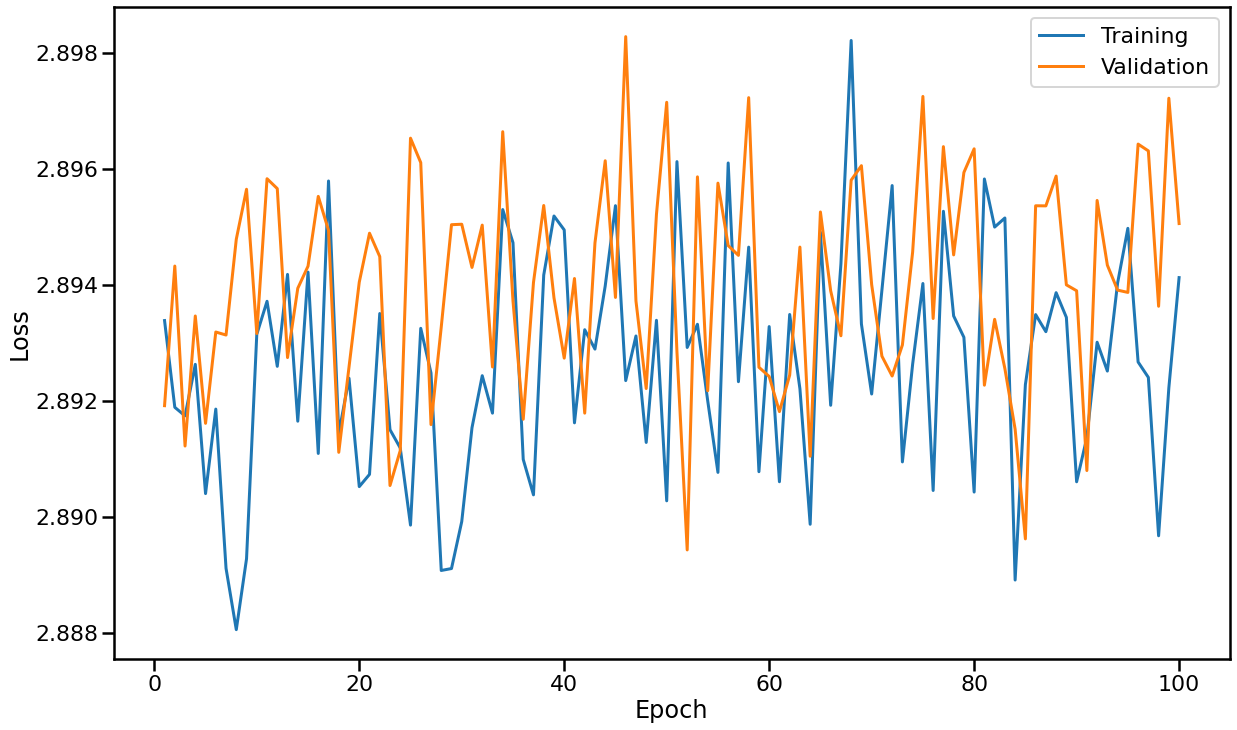

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 5

In [79]:
criterion5 = nn.NLLLoss()
learning_rate = 0.001
optimizer5 = torch.optim.Adam(rnn.parameters(),lr= learning_rate)

In [80]:
optimizer5

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [81]:
def train2(category_tensor, line_tensor, optimizer):
    hidden = rnn2.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn2(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion5(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [82]:
def val2(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion5(output, category_tensor.to(device))

    return output, loss.item()


In [88]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn2, optimizer5, criterion5)


5000 5% (0m 36s) 2.8083 Mccallum / Japanese ✗ (Scottish)
10000 10% (1m 12s) 2.9004 Bertsimas / Scottish ✗ (Greek)
15000 15% (1m 48s) 2.8877 Hadad / Italian ✗ (Arabic)
20000 20% (2m 22s) 2.8732 Oichi / Scottish ✗ (Japanese)
25000 25% (2m 57s) 2.8564 Baik / Irish ✗ (Korean)
30000 30% (3m 32s) 2.8712 Yasui / Scottish ✗ (Japanese)
35000 35% (4m 7s) 2.9002 Arvanitoyannis / Scottish ✗ (Greek)
40000 40% (4m 43s) 2.7931 Nishihara / Japanese ✓
45000 45% (5m 17s) 2.7658 Vico / Scottish ✗ (Italian)
50000 50% (5m 52s) 2.8792 Mcintyre / Italian ✗ (Scottish)
55000 55% (6m 28s) 2.9268 Romeijn / Italian ✗ (Dutch)
60000 60% (7m 3s) 2.8709 Chweh / Scottish ✗ (Korean)
65000 65% (7m 41s) 2.8986 Africani / Scottish ✗ (Italian)
70000 70% (8m 18s) 2.8724 Tsukawaki / Scottish ✗ (Japanese)
75000 75% (8m 58s) 3.0135 Gagnon / Italian ✗ (French)
80000 80% (9m 34s) 2.8869 Mifsud / Italian ✗ (Arabic)


KeyboardInterrupt: ignored

In [ ]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Hyperparameter tuning case 6

In [ ]:
criterion6 = nn.NLLLoss()
learning_rate = 0.01
optimizer6 = torch.optim.Adam(rnn.parameters(),lr= learning_rate)

In [ ]:
def train2(category_tensor, line_tensor, optimizer):
    hidden = rnn2.hidf().to(device)
    line_tensor = line_tensor.to(device)

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn2(line_tensor[i], hidden)

    optimizer.zero_grad()
    loss = criterion6(output, category_tensor.to(device))
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [ ]:
def val2(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.hidf().to(device)
        line_tensor = line_tensor.to(device)

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion6(output, category_tensor.to(device))

    return output, loss.item()


In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor):
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def validation_iteration(rnn, criterion, category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output, loss.item()

def train_model(n_iters, print_every, plot_every, rnn, optimizer, criterion):
    start = time.time()
    best_loss=float('inf')
    current_loss = 0
    current_loss_val = 0
    all_losses = []
    all_losses_val = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

        output, loss = train_iteration(optimizer, criterion, rnn, category_tensor, line_tensor)
        output_val, loss_val = validation_iteration(rnn, criterion, category_tensor_v, line_tensor_v)
        current_loss += loss
        current_loss_val += loss_val

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            if current_loss_val < best_loss:
                best_loss = current_loss_val
                torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model.pth')
            current_loss = 0
            current_loss_val = 0

    return all_losses, all_losses_val

# Example usage
all_losses, all_val_losses = train_model(n_iters, print_every, plot_every, rnn2, optimizer6, criterion6)


In [ ]:
all_losses_val=[i.detach().cpu().numpy() for i in all_losses_val]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.plot(range(1, len(all_losses) + 1), all_losses, label='Training')
plt.plot(range(1, len(all_losses_val) + 1), all_losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
def evaluate(line_tensor):
    hidden = rnn2.hidf()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn2(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [62]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-2.80) French
(-2.82) Portuguese
(-2.82) Polish

> Jackson
(-2.76) French
(-2.76) Czech
(-2.81) English

> Satoshi
(-2.78) Czech
(-2.79) Polish
(-2.81) English


##Loading the best model & Confusion Matrix

tensor([[  0.,   0.,  19.,   0.,  32.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   3.,   0.,   9.,  10.,   0.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  31.,   0.,  16.,  26.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   2.,   0.,   9.,  13.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  13.,  16.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  10.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   7.,   0.,   7.,  13.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0

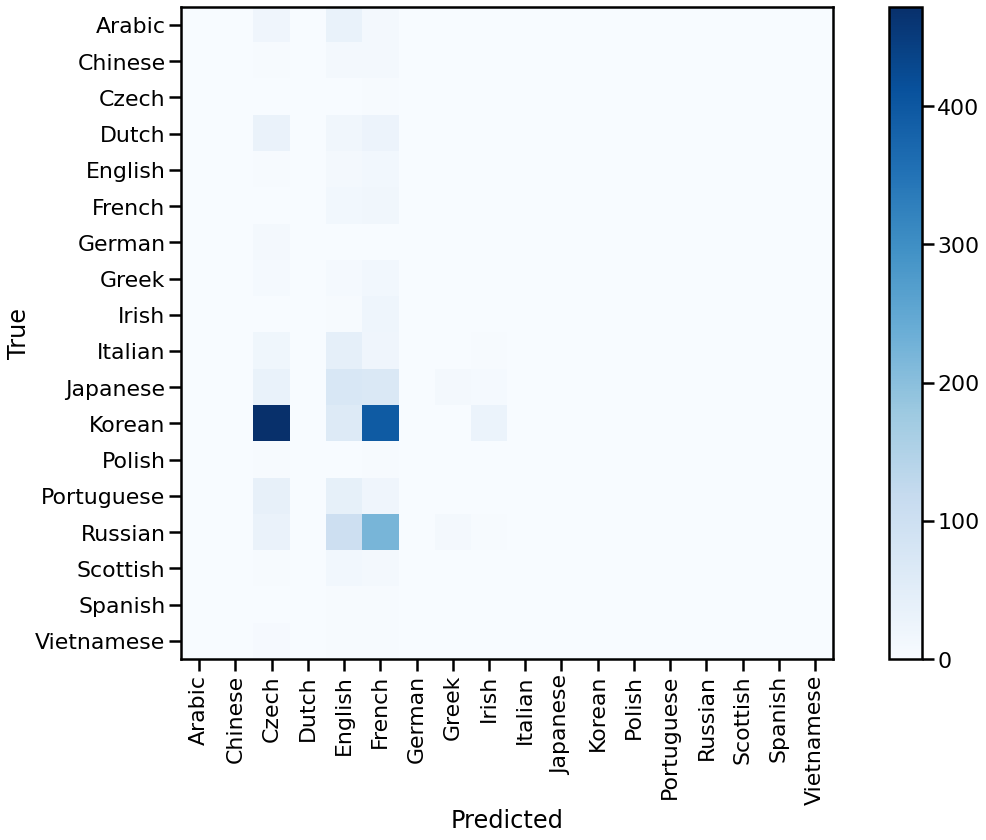

In [65]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
PATH = '/content/drive/MyDrive/DL Lab4/best_model_with_extra_layers.pth'
model = RNN(n_letters, n_hidden, n_categories).to(device)
model = torch.load(PATH)

#Putting model in evaluation mode
rnn.eval()

# Create confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# print(confusion[0][0])
# with torch.no_grad():
# for i in val_categories:
#   print(i)
val_cat_dict={'Czech':0,
  'Dutch':1,
  'Portuguese':2,
  'Italian':3,
  'Irish':4,
  'French':5,
  'Polish':6,
  'Chinese':7,
  'Greek':8,
  'German':9,
  'Arabic':10,
  'Russian':11,
  'Korean':12,
  'Japanese':13,
  'English':14,
  'Spanish':15,
  'Scottish':16,
  'Vietnamese':17}
for i in range(len(val_categories)):
    output = evaluate(val_lines[i])
    guess = torch.argmax(output)
    category_i = val_cat_dict[val_categories[i]]
    # print(guess,' ',category_i)
    confusion[category_i][guess]+=1

# Print confusion matrix
print(confusion)

# Plot confusion matrix
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))
sns.set_context('poster')
plt.imshow(confusion.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(all_categories))
plt.xticks(tick_marks, all_categories, rotation=90)
plt.yticks(tick_marks, all_categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Stacked RNN

In [ ]:
import torch.nn as nn

# Define the number of units for the RNN layers
num_units = 128

# Define the stacked RNN model
class StackedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StackedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = RNN(input_size, hidden_size, hidden_size)
        self.rnn2 = RNN(hidden_size, hidden_size, output_size)

    def forward(self, input, hidden1=None, hidden2=None):
        if hidden1 is None:
            hidden1 = self.rnn1.hidf()
        if hidden2 is None:
            hidden2 = self.rnn2.hidf()

        output1 = self.rnn1(input, hidden1)
        output2 = self.rnn2(output1, hidden2)

        return output2


    def hidf(self):
        return torch.zeros(1, self.hidden_size)

rnn3 = StackedRNN(n_letters, n_hidden, n_categories)

In [76]:
device

device(type='cuda')

In [85]:
def train3(category_tensor, line_tensor,optimizer):
    hidden = rnn3.hidf()
    line_tensor = line_tensor
    hidden = hidden
    rnn3.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn3(line_tensor[i], hidden)
    # print(output,' ',category_tensor)
    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [80]:
def val3(category_tensor, line_tensor):
   with torch.no_grad():
        hidden = rnn3.hidf()
        hidden = hidden
        line_tensor =line_tensor
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn3(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        return output,loss

In [85]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
current_loss_val=0
all_losses = []
all_losses_val=[]
# best_loss=float('inf')

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
best_loss=float('inf')
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    category_v, line_v, category_tensor_v, line_tensor_v = randomValidationExample()

    output, loss = train3(category_tensor, line_tensor,optimizer2)
    output_val,loss_val=val3(category_tensor_v,line_tensor_v)
    current_loss += loss
    current_loss_val += loss_val

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        all_losses_val.append(current_loss_val/plot_every)
        if current_loss_val<best_loss:
          best_loss=current_loss_val
          torch.save(rnn.state_dict(),'/content/drive/MyDrive/DL Lab4/best_model_final.pth')
        current_loss = 0
        current_loss_val = 0

5000 5% (0m 33s) 2.9246 Molotkov / Scottish ✗ (Russian)
10000 10% (1m 5s) 2.8630 Baba / Japanese ✗ (Arabic)
15000 15% (1m 37s) 2.9227 Vickerman / Italian ✗ (English)
20000 20% (2m 16s) 2.8383 Wiater / Japanese ✗ (Polish)
25000 25% (2m 51s) 2.9306 Ngo / Scottish ✗ (Vietnamese)
30000 30% (3m 23s) 2.9647 Alves / Scottish ✗ (Portuguese)
35000 35% (3m 59s) 2.8984 Morandi / Scottish ✗ (Italian)
40000 40% (4m 38s) 2.9335 Woodhead / Italian ✗ (English)
45000 45% (5m 10s) 2.8546 Zhi / Scottish ✗ (Chinese)
50000 50% (5m 44s) 2.9350 Marquerink / Irish ✗ (German)
55000 55% (6m 23s) 2.8065 Kennedy / Italian ✗ (Scottish)
60000 60% (7m 7s) 3.0066 Huffman / Italian ✗ (German)
65000 65% (7m 47s) 2.9647 Fernandes / Scottish ✗ (Portuguese)
70000 70% (8m 30s) 2.8523 Chung / Japanese ✗ (Korean)
75000 75% (9m 12s) 2.9017 Ramos / Scottish ✗ (Spanish)
80000 80% (9m 52s) 2.8682 Qiu / Scottish ✗ (Chinese)
85000 85% (10m 27s) 2.8421 Govier / Japanese ✗ (English)
90000 90% (11m 2s) 2.9575 Eizenstein / Italian ✗ (

In [ ]:
def evaluate(line_tensor):
    hidden = rnn3.hidf()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn3(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [87]:
predict('Emilia')
predict('Alexandra')
predict('Sachiko')
predict('Vladimir')
predict('Minh')
predict('Xi')
predict('Muammar')
predict('Mukesh')
predict('Andrew')
predict('Ronaldo')

> Emilia
(-1.47) Italian
(-1.50) Greek
(-1.60) Spanish

> Alexandra
(-1.28) Spanish
(-1.57) Italian
(-1.63) Czech

> Sachiko
(-1.25) Korean
(-1.58) Russian
(-1.85) Vietnamese

> Vladimir
(-1.42) Russian
(-1.58) German
(-2.04) Scottish

> Minh
(-0.05) Vietnamese
(-3.84) Korean
(-4.13) Chinese

> Xi
(-0.09) Korean
(-3.28) Chinese
(-3.83) Japanese

> Muammar
(-0.49) Arabic
(-2.40) French
(-2.82) Czech

> Mukesh
(-0.58) Arabic
(-2.04) Russian
(-2.23) Vietnamese

> Andrew
(-1.32) Russian
(-1.64) English
(-1.66) Polish
> Ronaldo
(-0.40) Italian
(-1.94) Spanish
(-2.15) Portuguese

